# EXPLORATORY DATA ANALYSIS (EDA)

## EDA Checklist

1. What is the question that we are trying to solve?
2. What are the data types and how to treat different types?
3. Where are the outliers and should we care about them?
4. What is missing from the data and what to do about it?
5. How to add, change or remove variables to extract more information of the data?

## Initial Setup

In [71]:
import pandas as pd
from pandas.api.types import is_categorical_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from scipy import stats
import sys
import os
from sklearn.ensemble import RandomForestClassifier
from rfpimp import *

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

np.random.seed(32294)

%matplotlib inline
sns.set_context('notebook')
sns.set_style("white", {"axes.spines.right": "False", "axes.spines.top": "False"})

In [2]:
file_market = '../data/raw/estaticos_market.csv'

data_raw = pd.read_csv(file_market, index_col=0)

# What are the data types and how to treat different types?

First, let's take a look at the data

In [3]:
data_raw.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,dt_situacao,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,fl_optante_simples,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,vl_potenc_cons_oleo_gas,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,de_indicador_telefone,fl_simples_irregular,vl_frota,empsetorcensitariofaixarendapopulacao,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,qt_socios_st_suspensa,qt_socios_masculino,qt_socios_feminino,qt_socios_pep,qt_alteracao_socio_total,qt_alteracao_socio_90d,qt_alteracao_socio_180d,qt_alteracao_socio_365d,qt_socios_pj_ativos,qt_socios_pj_nulos,qt_socios_pj_baixados,qt_socios_pj_suspensos,qt_socios_pj_inaptos,vl_idade_media_socios_pj,vl_idade_maxima_socios_pj,vl_idade_minima_socios_pj,qt_coligados,qt_socios_coligados,qt_coligados_matriz,qt_coligados_ativo,qt_coligados_baixada,qt_coligados_inapta,qt_coligados_suspensa,qt_coligados_nula,idade_media_coligadas,idade_maxima_coligadas,idade_minima_coligadas,coligada_mais_nova_ativa,coligada_mais_antiga_ativa,idade_media_coligadas_ativas,coligada_mais_nova_baixada,coligada_mais_antiga_baixada,idade_media_coligadas_baixadas,qt_coligados_sa,qt_coligados_me,qt_coligados_mei,qt_coligados_ltda,qt_coligados_epp,qt_coligados_norte,qt_coligados_sul,qt_coligados_nordeste,qt_coligados_centro,qt_coligados_sudeste,qt_coligados_exterior,qt_ufs_coligados,qt_regioes_coligados,qt_ramos_coligados,qt_coligados_industria,qt_coligados_agropecuaria,qt_coligados_comercio,qt_coligados_serviço,qt_coligados_ccivil,qt_funcionarios_coligados,qt_funcionarios_coligados_gp,media_funcionarios_coligados_gp,max_funcionarios_coligados_gp,min_funcionarios_coligados_gp,vl_folha_coligados,media_vl_folha_coligados,max_vl_folha_coligados,min_vl_folha_coligados,vl_folha_coligados_gp,media_vl_folha_coligados_gp,max_vl_folha_coligados_gp,min_vl_folha_coligados_gp,faturamento_est_coligados,media_faturamento_est_coligados,max_faturamento_est_coligados,min_faturamento_est_coligados,faturamento_est_coligados_gp,media_faturamento_est_coligados_gp,max_faturamento_est_coligados_gp,min_faturamento_est_coligados_gp,total_filiais_coligados,media_filiais_coligados,max_filiais_coligados,min_filiais_coligados,qt_coligados_atividade_alto,qt_coligados_atividade_medio,qt_coligados_atividade_baixo,qt_coligados_atividade_mt_baixo,qt_coligados_atividade_inativo,qt_coligadas,sum_faturamento_estimado_coligadas,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,idade_ate_18,idade_de_19_a_23,idade_de_24_a_28,idade_de_29_a_33,idade_de_34_a_38,idade_de_39_a_43,idade_de_44_a_48,idade_de_49_a_53,idade_de_54_a_58,idade_acima_de_58,grau_instrucao_macro_analfabeto,grau_instrucao_macro_escolaridade_fundamental,grau_instrucao_macro_escolaridade_media,grau_instrucao_macro_escolaridade_superior,grau_instrucao_macro_desconhecido,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,False,Fals

In [4]:
print(data_raw.shape)

(462298, 181)


We have 181 features from which we will verify the data types.

Which data types do we currently have? Let's split and analyse each one individually.

In [5]:
data_raw.dtypes.value_counts()

float64    144
object      27
bool         9
int64        1
dtype: int64

## Features type int64

In [6]:
data_raw_int = data_raw.select_dtypes(include='int64'); data_raw_int.columns

Index(['qt_filiais'], dtype='object')

The only feature with this data type is 'qtd_filias'. It has the correct data type according with the data dictionary.

Let's check the basic statistics for this feature.

In [7]:
data_raw_int.describe()

,qt_filiais
count,462298.000000
mean,28.737044
std,468.626094
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9647.000000


As we can see, the mean is much lower than the standard deviation, which imply that we have a very disproportional distribution. This is expected as most companies don't have branches and, therefore, we have a peak at 'qt_filiais' = 0. From the data, approximately 90% of the companies do not have branches.

In [8]:
data_raw_int[data_raw_int['qt_filiais'] == 0].count()/len(data_raw_int['qt_filiais'])

qt_filiais    0.904272
dtype: float64

At last, as the minimum and maximum values are small, we will update the type to int8, to optimize memory consumption.

In [9]:
data_raw_int = data_raw_int.astype('int8')

## Features type bool

In [10]:
data_raw_bool = data_raw.select_dtypes(include='bool'); data_raw_bool.columns

Index(['fl_matriz', 'fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 'fl_ltda',
       'fl_st_especial', 'fl_email', 'fl_telefone'],
      dtype='object')

According to the data dictionary, this features are all which the correct data type, boolean.

Let's take a look to see if everything is ok.

In [11]:
data_raw_bool.head()

,fl_matriz,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone
0,True,False,False,False,False,False,False,True,True
1,True,False,False,False,True,False,False,True,True
2,True,False,False,False,True,False,False,False,True
3,True,False,False,False,False,False,False,True,True
4,True,False,False,False,False,False,False,True,True


## Features type object

In [12]:
data_raw_object = data_raw.select_dtypes(include='object'); data_raw_object.columns

Index(['id', 'de_natureza_juridica', 'sg_uf', 'natureza_juridica_macro',
       'de_ramo', 'setor', 'idade_emp_cat', 'dt_situacao', 'fl_rm',
       'nm_divisao', 'nm_segmento', 'fl_spa', 'fl_antt', 'fl_veiculo',
       'fl_optante_simples', 'fl_optante_simei', 'sg_uf_matriz',
       'de_saude_tributaria', 'de_saude_rescencia', 'de_nivel_atividade',
       'de_indicador_telefone', 'fl_simples_irregular', 'nm_meso_regiao',
       'nm_micro_regiao', 'fl_passivel_iss', 'de_faixa_faturamento_estimado',
       'de_faixa_faturamento_estimado_grupo'],
      dtype='object')

Just by looking at the column names we can see that multiple columns start with 'fl_' which, according to the data dictionary, are boolean. Let's take a look at those.

### Features that start with 'fl_'

In [13]:
fl_object_cols = [col for col in data_raw_object.columns if 'fl_' in col]

In [14]:
data_raw_object[fl_object_cols].head()

,fl_rm,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,fl_optante_simei,fl_simples_irregular,fl_passivel_iss
0,SIM,False,False,False,True,False,False,True
1,SIM,False,False,False,NaN,NaN,False,True
2,SIM,False,False,False,True,True,False,True
3,SIM,False,False,False,True,False,False,True
4,SIM,False,False,False,True,False,False,True


Looking at the data, all but the first feature are ok, they have the object type because of the missing values, as we can see below.

In [15]:
data_raw_object[fl_object_cols].isna().sum()

fl_rm                       0
fl_spa                   1927
fl_antt                  1927
fl_veiculo               1927
fl_optante_simples      82713
fl_optante_simei        82713
fl_simples_irregular     1927
fl_passivel_iss          1927
dtype: int64

For the first feature 'fl_rm', we will transform the values to boolean.

In [16]:
data_raw_object['fl_rm'] = pd.Series(np.where(data_raw_object['fl_rm'].values == 'SIM', True, False),
          data_raw_object['fl_rm'].index)

### Other features with type object

In [17]:
other_object_cols = [col for col in data_raw_object.columns if 'fl_' not in col]; other_object_cols

['id',
 'de_natureza_juridica',
 'sg_uf',
 'natureza_juridica_macro',
 'de_ramo',
 'setor',
 'idade_emp_cat',
 'dt_situacao',
 'nm_divisao',
 'nm_segmento',
 'sg_uf_matriz',
 'de_saude_tributaria',
 'de_saude_rescencia',
 'de_nivel_atividade',
 'de_indicador_telefone',
 'nm_meso_regiao',
 'nm_micro_regiao',
 'de_faixa_faturamento_estimado',
 'de_faixa_faturamento_estimado_grupo']

The feature 'id' is a alphanumerical identifier of the data, let's drop it because it is not a generalizer

In [18]:
del data_raw_object['id']
other_object_cols.remove('id')

The feature 'dt_situacao' is a date, let's transform it's type.

In [19]:
data_raw_object['dt_situacao'] = pd.to_datetime(data_raw_object['dt_situacao'])
other_object_cols.remove('dt_situacao')

The remaining features are all categorical.

In [20]:
data_raw_object[other_object_cols] = data_raw_object[other_object_cols].astype('category')

## Features type float64

In [21]:
data_raw_float = data_raw.select_dtypes(include='float64'); data_raw_float.columns

Index(['idade_empresa_anos', 'vl_total_tancagem', 'vl_total_veiculos_antt',
       'vl_total_veiculos_leves', 'vl_total_veiculos_pesados', 'qt_art',
       'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo',
       'vl_total_tancagem_grupo', 'vl_total_veiculos_antt_grupo',
       ...
       'min_meses_servicos_all', 'media_meses_servicos', 'max_meses_servicos',
       'min_meses_servicos', 'qt_funcionarios', 'qt_funcionarios_12meses',
       'qt_funcionarios_24meses', 'tx_crescimento_12meses',
       'tx_crescimento_24meses', 'tx_rotatividade'],
      dtype='object', length=144)

In [22]:
data_raw_float.describe().T

,count,mean,std,min,25%,50%,75%,max
idade_empresa_anos,462298.0,9.948677e+00,9.615664e+00,0.016438,2.756164,6.704110,1.446575e+01,1.064329e+02
vl_total_tancagem,280.0,3.201429e+01,8.128017e+01,1.000000,15.000000,15.000000,3.000000e+01,1.215000e+03
vl_total_veiculos_antt,176.0,3.818182e+00,6.797555e+00,0.000000,1.000000,2.000000,4.000000e+00,5.000000e+01
vl_total_veiculos_leves,30684.0,2.244329e+00,9.572536e+00,0.000000,0.000000,1.000000,2.000000e+00,4.890000e+02
vl_total_veiculos_pesados,30684.0,1.177813e+00,6.589059e+00,0.000000,0.000000,0.000000,1.000000e+00,3.630000e+02
qt_art,6590.0,5.769044e+00,2.545095e+01,1.000000,1.000000,2.000000,4.000000e+00,1.017000e+03
vl_total_veiculos_pesados_grupo,460371.0,3.591801e+00,7.260035e+01,0.000000,0.000000,0.000000,0.000000e+00,9.782000e+03
vl_total_veiculos_leves_grupo,460371.0,4.869918e+01,1.206697e+03,0.000000,0.000000,0.000000,0.000000e+00,1.220900e+05
vl_total_tancagem_grupo,1760.0,1.345972e+02,6.837745e+02,1.000000,15.000000,15.000000,6.625000e+01,1.192200e+04
vl_total_veiculos_antt_grupo,336.0,1.593452e+01,2.970866e+01,0.000000,1.000000,3.000000,8.000000e+00,1.080000e+02


Looking at the data, we don't have any feature that has the wrong data type

At last, we will merge all the dataframes into one again.

In [23]:
dfs = [data_raw_bool, data_raw_float, data_raw_int, data_raw_object]
data_types = pd.concat(dfs,axis=1)

In [24]:
data_types.shape

(462298, 180)

# Where are the outliers and should we care about them?

Given the caracteristics of this dataset, features that describe a company, we are going to have outliers, and that is normal, because there are companies of lots of different sizes and organizations in the same dataset.

In [25]:
data_outliers = data_types.select_dtypes(include=['int8','float64']); data_outliers.columns

Index(['idade_empresa_anos', 'vl_total_tancagem', 'vl_total_veiculos_antt',
       'vl_total_veiculos_leves', 'vl_total_veiculos_pesados', 'qt_art',
       'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo',
       'vl_total_tancagem_grupo', 'vl_total_veiculos_antt_grupo',
       ...
       'media_meses_servicos', 'max_meses_servicos', 'min_meses_servicos',
       'qt_funcionarios', 'qt_funcionarios_12meses', 'qt_funcionarios_24meses',
       'tx_crescimento_12meses', 'tx_crescimento_24meses', 'tx_rotatividade',
       'qt_filiais'],
      dtype='object', length=145)

## Features that start with 'idade_'

In [26]:
data_outliers[[col for col in data_outliers.columns if col[:6] == 'idade_']].describe().T

,count,mean,std,min,25%,50%,75%,max
idade_empresa_anos,462298.0,9.948677,9.615664,0.016438,2.756164,6.704110,14.465753,106.432877
idade_media_socios,310696.0,42.816452,12.626447,-2.000000,33.000000,42.000000,51.000000,127.000000
idade_maxima_socios,310696.0,44.344131,13.930385,-2.000000,34.000000,43.000000,54.000000,127.000000
idade_minima_socios,310696.0,41.355225,12.514921,-2.000000,32.000000,40.000000,50.000000,127.000000
idade_media_coligadas,65391.0,159.171741,107.517745,0.600000,80.758333,135.933333,218.566667,910.333333
idade_maxima_coligadas,65391.0,227.625171,165.354103,0.600000,99.533333,193.666667,315.066667,1358.166667
idade_minima_coligadas,65391.0,111.375456,107.846354,0.600000,30.333333,79.066667,158.766667,910.333333
idade_media_coligadas_ativas,65147.0,159.137019,107.734131,0.600000,80.433333,135.803846,218.958333,910.333333
idade_media_coligadas_baixadas,136.0,134.467034,115.927221,0.800000,60.766667,89.500000,173.608333,634.200000
idade_ate_18,2906.0,2.197866,6.295785,1.000000,1.000000,1.000000,2.000000,258.000000


Looking at the features 'idade_media_socios', 'idade_maxima_socios' and 'idade_minima_socios', we can see that there are negative values.

Taking into consideration the Brazilian legislation, minors under 16 cannot be partner of a company. Therefore, we will replace ages under 16 to the minimum age allowed by law

http://newaccount.com.br/qual-idade-minima-para-ser-socio-de-uma-empresa/

In [27]:
data_types.loc[data_types['idade_maxima_socios']<16, 'idade_maxima_socios'] = 16
data_types.loc[data_types['idade_minima_socios']<16, 'idade_minima_socios'] = 16
data_types.loc[data_types['idade_media_socios']<16, 'idade_media_socios'] = 16

The features based on ages of connected companies raise concern because of the high maximum values. However, we could not justify the drop of the features or the replacement by any other value.

## Features that start with 'qt_'

In [28]:
data_outliers[[col for col in data_outliers.columns if col[:3] == 'qt_']].describe().T

,count,mean,std,min,25%,50%,75%,max
qt_art,6590.0,5.769044,25.450950,1.0,1.0,2.0,4.0,1017.0
qt_socios,347207.0,1.496326,3.276626,1.0,1.0,1.0,2.0,246.0
qt_socios_pf,347207.0,1.476681,3.258079,0.0,1.0,1.0,2.0,246.0
qt_socios_pj,347207.0,0.019645,0.195166,0.0,0.0,0.0,0.0,13.0
qt_socios_st_regular,307381.0,1.396082,2.578793,1.0,1.0,1.0,1.0,179.0
qt_socios_st_suspensa,3251.0,1.048600,0.234239,1.0,1.0,1.0,1.0,6.0
qt_socios_masculino,195115.0,1.353925,2.848980,1.0,1.0,1.0,1.0,84.0
qt_socios_feminino,145029.0,1.107117,0.840194,1.0,1.0,1.0,1.0,140.0
qt_socios_pep,6743.0,5.992437,14.675005,1.0,1.0,1.0,3.0,163.0
qt_alteracao_socio_total,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, there are negative values for the feature 'qt_filiais'. Let's replace this values to 0.

In [29]:
data_types.loc[data_types['qt_filiais']<0, 'qt_filiais'] = 0

## Features that start with 'vl_'

In [30]:
data_outliers[[col for col in data_outliers.columns if col[:3] == 'vl_']].describe().T

,count,mean,std,min,25%,50%,75%,max
vl_total_tancagem,280.0,3.201429e+01,8.128017e+01,1.00,15.000000,15.000000,3.000000e+01,1.215000e+03
vl_total_veiculos_antt,176.0,3.818182e+00,6.797555e+00,0.00,1.000000,2.000000,4.000000e+00,5.000000e+01
vl_total_veiculos_leves,30684.0,2.244329e+00,9.572536e+00,0.00,0.000000,1.000000,2.000000e+00,4.890000e+02
vl_total_veiculos_pesados,30684.0,1.177813e+00,6.589059e+00,0.00,0.000000,0.000000,1.000000e+00,3.630000e+02
vl_total_veiculos_pesados_grupo,460371.0,3.591801e+00,7.260035e+01,0.00,0.000000,0.000000,0.000000e+00,9.782000e+03
vl_total_veiculos_leves_grupo,460371.0,4.869918e+01,1.206697e+03,0.00,0.000000,0.000000,0.000000e+00,1.220900e+05
vl_total_tancagem_grupo,1760.0,1.345972e+02,6.837745e+02,1.00,15.000000,15.000000,6.625000e+01,1.192200e+04
vl_total_veiculos_antt_grupo,336.0,1.593452e+01,2.970866e+01,0.00,1.000000,3.000000,8.000000e+00,1.080000e+02
vl_potenc_cons_oleo_gas,3683.0,1.589213e+01,7.523068e+01,1.00,2.000000,4.000000,1.000000e+01,3.645000e+03
vl_frota,24190.0,1.694226e+05,8.549075e+05,1126.00,26205.000000,51693.000000,1.165000e+05,5.585830e+07


The features related to the value of vehicles raises concern, because there are a lot of values with small values, like 1 and 2, that could be associated with vehicle values. However, we could not justify the drop of these features or the replacement by any other value.

## Remaining features

In [31]:
outliers_cols = data_outliers.columns

In [32]:
outliers_cols = list(set(outliers_cols) - set([col for col in data_outliers.columns if col[:6] == 'idade_']))
outliers_cols = list(set(outliers_cols) - set([col for col in data_outliers.columns if col[:3] == 'qt_']))
outliers_cols = list(set(outliers_cols) - set([col for col in data_outliers.columns if col[:3] == 'vl_']))

In [33]:
data_outliers[outliers_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
min_filiais_coligados,20400.0,4.425539e+00,6.486056e+01,1.000000,1.000000,1.000000,2.000000e+00,6.278000e+03
media_meses_servicos,76261.0,5.806050e+01,1.429513e+02,1.933333,25.203704,43.533333,6.888333e+01,5.099067e+03
tx_crescimento_24meses,74014.0,-5.834288e+00,4.438258e+02,-100.000000,-44.444444,0.000000,0.000000e+00,8.730000e+04
percent_func_genero_fem,75942.0,4.430058e+01,3.904441e+01,0.000000,0.000000,40.000000,8.333000e+01,1.000000e+02
coligada_mais_antiga_ativa,65147.0,2.275123e+02,1.655064e+02,0.600000,99.050000,193.566667,3.151333e+02,1.358167e+03
min_faturamento_est_coligados,64523.0,8.986427e+05,1.205634e+07,0.000000,210000.000000,210000.000000,2.100000e+05,8.735568e+08
coligada_mais_nova_baixada,136.0,1.304755e+02,1.172914e+02,0.800000,60.766667,83.733333,1.736083e+02,6.342000e+02
total_filiais_coligados,20400.0,6.030127e+01,3.071704e+02,1.000000,1.000000,3.000000,1.400000e+01,7.910000e+03
media_vl_folha_coligados,36314.0,5.863275e+06,3.340987e+07,0.000000,175154.394531,484250.390625,1.792757e+06,1.205969e+09
media_filiais_coligados,20400.0,9.492187e+00,7.231604e+01,1.000000,1.000000,2.000000,4.400000e+00,6.278000e+03


As we can see, there are negative values for the features that end with '_meses_servicos_all'.
Let's replace these with the minimum values greater than 0.

In [34]:
min_meses_servicos_all = data_outliers.loc[data_outliers['min_meses_servicos_all']>0, 'min_meses_servicos_all'].min()
media_meses_servicos_all = data_outliers.loc[data_outliers['media_meses_servicos_all']>0, 'media_meses_servicos_all'].min()
max_meses_servicos_all = data_outliers.loc[data_outliers['max_meses_servicos_all']>0, 'max_meses_servicos_all'].min()

In [35]:
data_types.loc[data_types['min_meses_servicos_all']<0, 'min_meses_servicos_all'] = min_meses_servicos_all
data_types.loc[data_types['media_meses_servicos_all']<0, 'media_meses_servicos_all'] = media_meses_servicos_all
data_types.loc[data_types['max_meses_servicos_all']<0, 'max_meses_servicos_all'] = max_meses_servicos_all

## Date feature

In [36]:
data_types['dt_situacao'].describe()

count                  462292
unique                   7334
top       2005-11-03 00:00:00
freq                    69465
first     1912-06-18 00:00:00
last      2018-10-22 00:00:00
Name: dt_situacao, dtype: object

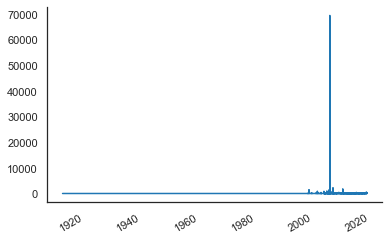

In [37]:
data_types['dt_situacao'].value_counts().sort_index().plot()

Since the data dictonary is not clear on the meaning of this feature, we can't eval if the values are ok or not. 

# What is missing from the data and what to do about it?

Here is how we will deal with missing data:
- For numeric columns, we replace missing values with the median/mean of that column and introduce a new boolean column that is true for any record where we replace a missing value.
- For nonnumeric columns simply is to leave them as-is with np.nan values.

I learned this method from Jermey Howard, from FastAI, the former CEO of Kaggle.

We will drop features that are 90% missing, as we don't have enough information to fill the missing values.

In [38]:
data_filt = data_types.dropna(thresh=len(data_types)*0.1, axis=1); 
print(f'Shape before columns dropped: {data_types.shape}')
print(f'Shape after columns dropped: {data_filt.shape}')

Shape before columns dropped: (462298, 180)
Shape after columns dropped: (462298, 122)


In [39]:
data_msg = data_filt.copy()

## Date feature

In [86]:
data_msg['dt_situacao_na'] = pd.isnull(data_msg['dt_situacao'])
data_msg['dt_situacao'].fillna(data_msg['dt_situacao'].mode()[0], inplace=True)
data_msg['year_dt_situacao'] = data_msg['dt_situacao'].dt.year
data_msg['month_dt_situacao'] = data_msg['dt_situacao'].dt.month
data_msg['day_dt_situacao'] = data_msg['dt_situacao'].dt.day
data_msg.drop('dt_situacao', axis=1, inplace=True)

## Numerical features

In [41]:
data_numerical = data_msg.select_dtypes(include=['int8', 'int64', 'float64'])

In [42]:
for col in data_numerical.columns:
    data_msg[col] = data_msg[col]
    data_msg[col+'_na'] = pd.isnull(data_msg[col])
    data_msg[col].fillna(data_msg[col].median(), inplace=True)

We are using the median to choose a number that is not going to skew the distribution of the data in that column. We are including a feature that we have replaced the missing data, because sometimes missing values are strongly predictive. This strategy is supported by recent academic research: https://hal.archives-ouvertes.fr/hal-02024202v2

In [87]:
data_msg.to_feather('../data/processed/market_msg')

# Data Exploration

In [88]:
data = pd.read_feather('../data/processed/market_msg'); data.shape

(462298, 216)

In [45]:
data.head()

,fl_matriz,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,empsetorcensitariofaixarendapopulacao,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,qt_socios_masculino,qt_socios_feminino,qt_coligados,qt_socios_coligados,qt_coligados_matriz,qt_coligados_ativo,qt_coligados_baixada,qt_coligados_inapta,qt_coligados_suspensa,qt_coligados_nula,idade_media_coligadas,idade_maxima_coligadas,idade_minima_coligadas,coligada_mais_nova_ativa,coligada_mais_antiga_ativa,idade_media_coligadas_ativas,qt_coligados_sa,qt_coligados_me,qt_coligados_mei,qt_coligados_ltda,qt_coligados_epp,qt_coligados_norte,qt_coligados_sul,qt_coligados_nordeste,qt_coligados_centro,qt_coligados_sudeste,qt_coligados_exterior,qt_ufs_coligados,qt_regioes_coligados,qt_ramos_coligados,qt_coligados_industria,qt_coligados_agropecuaria,qt_coligados_comercio,qt_coligados_serviço,qt_coligados_ccivil,faturamento_est_coligados,media_faturamento_est_coligados,max_faturamento_est_coligados,min_faturamento_est_coligados,faturamento_est_coligados_gp,media_faturamento_est_coligados_gp,max_faturamento_est_coligados_gp,min_faturamento_est_coligados_gp,qt_coligados_atividade_alto,qt_coligados_atividade_medio,qt_coligados_atividade_baixo,qt_coligados_atividade_mt_baixo,qt_coligados_atividade_inativo,qt_coligadas,sum_faturamento_estimado_coligadas,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,grau_instrucao_macro_escolaridade_media,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_emp_cat,dt_situacao,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,de_nivel_atividade,fl_simples_irregular,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,dt_situacao_na,year_dt_situacao,month_dt_situacao,day_dt_situacao,idade_empresa_anos_na,vl_total_veiculos_pesados_grupo_na,vl_total_veiculos_leves_grupo_na,nu_meses_rescencia_na,empsetorcensitariofaixarendapopulacao_na,qt_socios_na,qt_socios_pf_na,qt_socios_pj_na,idade_media_socios_na,idade_maxima_socios_na,idade_minima_socios_na,qt_socios_st_regular_na,qt_socios_masculino_na,qt_socios_feminino_na,qt_coligados_na,qt_socios_coligados_na,qt_coligados_matriz_na,qt_coligados_ativo_na,qt_coligados_baixada_na,qt_coligados_inapta_na,qt_coligados_suspensa_na,qt_coligados_nula_na,idade_media_coligadas_na,idade_maxima_coligadas_na,idade_minima_coligadas_na,coligada_mais_nova_ativa_na,coligada_mais_antiga_ativa_na,idade_media_coligadas_ativas_na,qt_coligados_sa_na,qt_coligados_me_na,qt_coligados_mei_na,qt_coligados_ltda_na,qt_coligados_epp_na,qt_coligados_norte_na,qt_coligados_sul_na,qt_coligados_nordeste_na,qt_coligados_centro_na,qt_coligados_sudeste_na,qt_coligados_exterior_na,qt_ufs_coligados_na,qt_regioes_coligados_na,qt_ramos_coligados_na,qt_coligados_industria_na,qt_coligados_agropecuaria_na,qt_coligados_comercio_na,qt_coligados_serviço_na,qt_coligados_ccivil_na,faturamento_est_coligados_na,media_faturamento_est_coligados_na,max_faturamento_est_coligados_na,min_faturamento_est_coligados_na,faturamento_est_coligados_gp_na,media_faturamento_est_coligados_gp_na,max_faturamento_est_coligados_gp_na,min_faturamento_est_coligados_gp_na,qt_coligados_atividade_alto_na,qt_coligados_atividade_medio_na,qt_coligados_atividade_baixo_na,qt_coligados_a

# How to add, change or remove variables to extract more information of the data?

## Label Encoding

### Categorical features

In [98]:
data_le = data.copy()

In [99]:
data_le_categorical = data_le.select_dtypes(include=['category'])

Since we have many columns, we ask ourselves if the feature fit one of these scenarios:
- The order of the categories in the feature matter?
- Is there already a category for nan values?

In [100]:
for col in data_le_categorical.columns:
    print('-------------------------------------------------------')
    print(col)
    print(data_le_categorical[col].unique())
    print('-------------------------------------------------------')

-------------------------------------------------------
de_natureza_juridica
[SOCIEDADE EMPRESARIA LIMITADA, EMPRESARIO INDIVIDUAL, COOPERATIVA, ASSOCIACAO PRIVADA, ENTIDADE SINDICAL, ..., SOCIEDADE SIMPLES EM NOME COLETIVO, FUNDO PRIVADO, ESTADO OU DISTRITO FEDERAL, ORGAO PUBLICO DO PODER LEGISLATIVO FEDERAL, ORGAO DE DIRECAO NACIONAL DE PARTIDO POLITICO]
Length: 67
Categories (67, object): [SOCIEDADE EMPRESARIA LIMITADA, EMPRESARIO INDIVIDUAL, COOPERATIVA, ASSOCIACAO PRIVADA, ..., FUNDO PRIVADO, ESTADO OU DISTRITO FEDERAL, ORGAO PUBLICO DO PODER LEGISLATIVO FEDERAL, ORGAO DE DIRECAO NACIONAL DE PARTIDO POLITICO]
-------------------------------------------------------
-------------------------------------------------------
sg_uf
[RN, PI, AM, MA, RO, AC]
Categories (6, object): [RN, PI, AM, MA, RO, AC]
-------------------------------------------------------
-------------------------------------------------------
natureza_juridica_macro
[ENTIDADES EMPRESARIAIS, OUTROS, ENTIDADES SEM FIN

For features that fit into one of the scenarios mentioned before, we will Label Encode manually, to take the order into consideration

In [101]:
idade_emp_cat_dict = {'<= 1': 0, '1 a 5': 1, '5 a 10' : 2, '10 a 15':3, '15 a 20' : 4, '> 20' : 5}
de_saude_rescencia_dict = {'SEM INFORMACAO': 0, 'ATE 3 MESES': 1, 'ATE 6 MESES' : 2, 'ATE 1 ANO':3, 'ACIMA DE 1 ANO':3}
de_nivel_atividade_dict = {'MUITO BAIXA': 1, 'BAIXA': 2, 'MEDIA' : 3, 'ALTA':4}
de_faixa_faturamento_estimado_dict = {'SEM INFORMACAO':0,
                                        'ATE R$ 81.000,00':1,
                                        'DE R$ 81.000,01 A R$ 360.000,00':1,
                                        'DE R$ 360.000,01 A R$ 1.500.000,00':2,
                                        'DE R$ 1.500.000,01 A R$ 4.800.000,00':2,
                                        'DE R$ 4.800.000,01 A R$ 10.000.000,00':3,
                                        'DE R$ 10.000.000,01 A R$ 30.000.000,00':3,
                                        'DE R$ 30.000.000,01 A R$ 100.000.000,00':4,
                                        'DE R$ 100.000.000,01 A R$ 300.000.000,00':5,
                                        'DE R$ 300.000.000,01 A R$ 500.000.000,00':5,
                                        'DE R$ 500.000.000,01 A 1 BILHAO DE REAIS':5,
                                        'ACIMA DE 1 BILHAO DE REAIS':5}
de_saude_tributaria_dict = {'VERDE': 1, 'AZUL': 2, 'AMARELO' : 3, 'CINZA':4, 'LARANJA':5, 'VERMELHO':6}

In [102]:
features_dict = {'idade_emp_cat':idade_emp_cat_dict,
                'de_saude_rescencia':de_saude_rescencia_dict,
                'de_nivel_atividade':de_nivel_atividade_dict,
                'de_faixa_faturamento_estimado':de_faixa_faturamento_estimado_dict,
                'de_faixa_faturamento_estimado_grupo':de_faixa_faturamento_estimado_dict,
                'de_saude_tributaria':de_saude_tributaria_dict}

In [103]:
for col in features_dict.keys():
    data_le[col] = data_le[col].map(features_dict[col])
    try:
        data_le[col].fillna(value=0, inplace=True)
    except ValueError:
        data_le[col] = data_le[col].cat.add_categories(0)
    data_le[col].fillna(value=0, inplace=True)
    data_le[col] = data_le[col].astype('int8')

For all other features, we will use the category code from pandas

In [104]:
for col in list(set(data_le_categorical.columns)-set(features_dict.keys())):
    data_le[col] = data_le[col].astype('category').cat.as_ordered()
    data_le[col] = data_le[col].cat.codes + 1

In [105]:
data_le_boolean_obj = data_le.select_dtypes(include='object')
for col in data_le_boolean_obj.columns:
    data_le[col] = data_le[col].astype('category').cat.as_ordered()
    data_le[col] = data_le[col].cat.codes + 1

In [106]:
num_cols = list(data_numerical.columns)
num_cols.extend(['year_dt_situacao','month_dt_situacao','day_dt_situacao'])
sc = StandardScaler()
data_le[data_numerical.columns] = pd.DataFrame(sc.fit_transform(data_le[data_numerical.columns]))

In [107]:
data_le.head()

,fl_matriz,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,empsetorcensitariofaixarendapopulacao,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,qt_socios_masculino,qt_socios_feminino,qt_coligados,qt_socios_coligados,qt_coligados_matriz,qt_coligados_ativo,qt_coligados_baixada,qt_coligados_inapta,qt_coligados_suspensa,qt_coligados_nula,idade_media_coligadas,idade_maxima_coligadas,idade_minima_coligadas,coligada_mais_nova_ativa,coligada_mais_antiga_ativa,idade_media_coligadas_ativas,qt_coligados_sa,qt_coligados_me,qt_coligados_mei,qt_coligados_ltda,qt_coligados_epp,qt_coligados_norte,qt_coligados_sul,qt_coligados_nordeste,qt_coligados_centro,qt_coligados_sudeste,qt_coligados_exterior,qt_ufs_coligados,qt_regioes_coligados,qt_ramos_coligados,qt_coligados_industria,qt_coligados_agropecuaria,qt_coligados_comercio,qt_coligados_serviço,qt_coligados_ccivil,faturamento_est_coligados,media_faturamento_est_coligados,max_faturamento_est_coligados,min_faturamento_est_coligados,faturamento_est_coligados_gp,media_faturamento_est_coligados_gp,max_faturamento_est_coligados_gp,min_faturamento_est_coligados_gp,qt_coligados_atividade_alto,qt_coligados_atividade_medio,qt_coligados_atividade_baixo,qt_coligados_atividade_mt_baixo,qt_coligados_atividade_inativo,qt_coligadas,sum_faturamento_estimado_coligadas,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_ex_funcionarios,qt_funcionarios_grupo,percent_func_genero_masc,percent_func_genero_fem,grau_instrucao_macro_escolaridade_media,total,meses_ultima_contratacaco,qt_admitidos_12meses,qt_desligados_12meses,qt_desligados,qt_admitidos,media_meses_servicos_all,max_meses_servicos_all,min_meses_servicos_all,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_emp_cat,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,de_nivel_atividade,fl_simples_irregular,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,dt_situacao_na,year_dt_situacao,month_dt_situacao,day_dt_situacao,idade_empresa_anos_na,vl_total_veiculos_pesados_grupo_na,vl_total_veiculos_leves_grupo_na,nu_meses_rescencia_na,empsetorcensitariofaixarendapopulacao_na,qt_socios_na,qt_socios_pf_na,qt_socios_pj_na,idade_media_socios_na,idade_maxima_socios_na,idade_minima_socios_na,qt_socios_st_regular_na,qt_socios_masculino_na,qt_socios_feminino_na,qt_coligados_na,qt_socios_coligados_na,qt_coligados_matriz_na,qt_coligados_ativo_na,qt_coligados_baixada_na,qt_coligados_inapta_na,qt_coligados_suspensa_na,qt_coligados_nula_na,idade_media_coligadas_na,idade_maxima_coligadas_na,idade_minima_coligadas_na,coligada_mais_nova_ativa_na,coligada_mais_antiga_ativa_na,idade_media_coligadas_ativas_na,qt_coligados_sa_na,qt_coligados_me_na,qt_coligados_mei_na,qt_coligados_ltda_na,qt_coligados_epp_na,qt_coligados_norte_na,qt_coligados_sul_na,qt_coligados_nordeste_na,qt_coligados_centro_na,qt_coligados_sudeste_na,qt_coligados_exterior_na,qt_ufs_coligados_na,qt_regioes_coligados_na,qt_ramos_coligados_na,qt_coligados_industria_na,qt_coligados_agropecuaria_na,qt_coligados_comercio_na,qt_coligados_serviço_na,qt_coligados_ccivil_na,faturamento_est_coligados_na,media_faturamento_est_coligados_na,max_faturamento_est_coligados_na,min_faturamento_est_coligados_na,faturamento_est_coligados_gp_na,media_faturamento_est_coligados_gp_na,max_faturamento_est_coligados_gp_na,min_faturamento_est_coligados_gp_na,qt_coligados_atividade_alto_na,qt_coligados_atividade_medio_na,qt_coligados_atividade_baixo_na,qt_coligados_atividade_mt_

In [108]:
data_le.to_feather('../data/processed/market_le')

## Feature Selection

In [109]:
data = pd.read_feather('../data/processed/market_le')

In [110]:
data['fl_portfolio'] = np.random.randint(0, 2, data.shape[0])

In [111]:
def get_feature_importance(X, y):
    rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    return importances(rf, X, y)

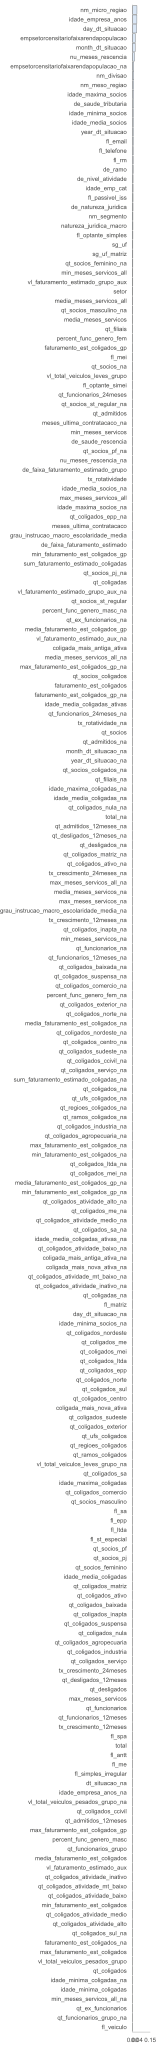

In [112]:
X, y = data.drop('fl_portfolio', axis=1), data['fl_portfolio']
I = get_feature_importance(X, y)
plot_importances(I)

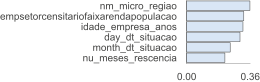

In [113]:
X, y = data[I[I.values > 0.01].index], data['fl_portfolio']
I = get_feature_importance(X, y)
plot_importances(I)